# Tetrahedrtal Interpolation

## Dots Into Continuum.

### Hey doc, I've got a sea of randomly arranged points, how do I get values between them?

Usually, when we're interpolating values we already have a nice even grid of values, so we can just take an algorithm that assumes the points are rectilinear (or spherical or whatever) and work with that.

Unfortunately, I have run into a situation where I have a random smattering of entirely uncorrelated points with lots of holes between them. I want to fill in those holes. There is no simple "just throw the algorithm onto it" solution for this, and I'll probably need to do it a lot. So, what we're going to make here is the Tetrahedral Interpolator. It'll take a 3D cloud of points and find the values in the middle. (Not the outside. No extrapolation in MY house!) 

The basic idea is that you input a 3D array in xyz, and it will fill in any empty slots. (You can define what value counts as "empty" at runtime). This will not upscale the data, for the simple reason that we can use other more efficient rectiliniar algorithms to do that once we're done here. But for now, we don't get to do that, as our points are scattered randomly all willy nilly. To begin... we are going to need some random points with random values.

And a block for initializing things.

In [3]:
#IMPORTS 
import csv
import math
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc
from scipy import ndimage
import statistics
import matplotlib.animation as animation
import random as rand
import pyvista as pv
#Are all of these necessary? Probably not, but I'll like to have them on hand anyway.

In [4]:
#STEP 1: Create a test 3D matrix!

testMatrix = [[[0 for x in range(5)] for x in range(5)] for x in range(5)]  #5x5x5 matrix of 0s.

points = 10
while (points > 0):
    X = rand.randint(0,4)
    Y = rand.randint(0,4)
    Z = rand.randint(0,4)
    V = rand.randint(0,4)
    testMatrix[X][Y][Z] = V
    points = points-1

print(testMatrix)

[[[0, 3, 0, 2, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 3], [0, 0, 0, 0, 0], [0, 0, 4, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[3, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [2, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 3, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]


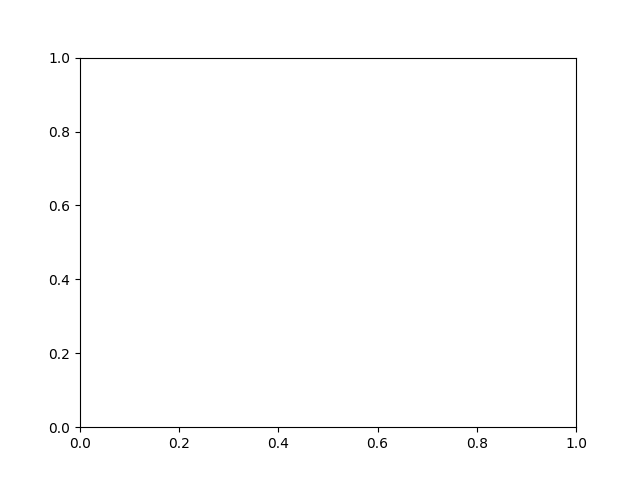

In [5]:
%matplotlib ipympl
#Stop the animation from interfering.

fig, ax = plt.subplots() #matplotlib's axis and figure notation is so annoying and obtuse...

xx = np.linspace(1, 5, 5)
yy = np.linspace(1, 5, 5)

def update(frame):
    ax.clear()
    zz = np.zeros((5, 5))
    for x in range(5):
        for y in range(5):
            zz[y][x] = testMatrix[x][y][frame]
    azimuth = ax.pcolor(zz)
    ax.set(title=str(frame))
    #ax.set(xlim=[-0.5,5.5], ylim=[-0.5,5.5])

ani = animation.FuncAnimation(fig, update, frames=5, interval=1000)

plt.show()

This is how the data will be given to us, as a matrix with a few points and then a bunch of zeros. The first thing we need to do is extract the points themselves from the array, so we know what we're dealing with.

[[0, 0, 1], [0, 0, 3], [1, 0, 4], [1, 2, 2], [2, 0, 0], [2, 2, 0], [2, 3, 0], [4, 1, 2]]


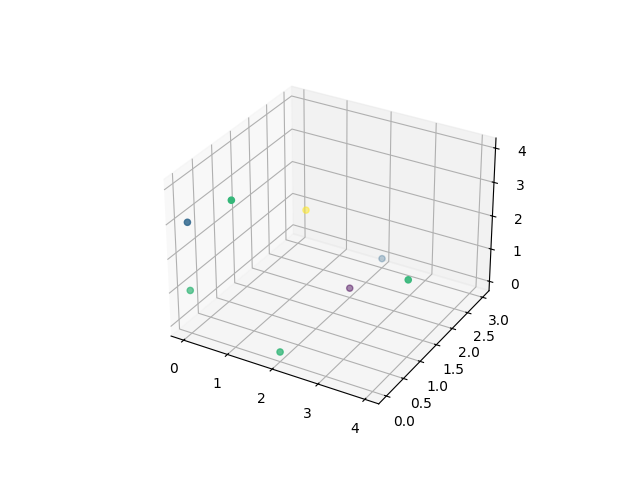

In [6]:
ani.pause()
#Stop the animation from interfering.

#Extract Points
index = []
xVals = []
yVals = []
zVals = []
wVals = []
pointArray = []
#We need this to be able to read in a general matrix, so treat it as if we don't know the matrix is 5x5.

i,j,k,l = 0,0,0,1.0
for x in range(len(testMatrix)):
    j = 0
    for y in range (len(testMatrix[0])):
        k = 0
        for z in range (len(testMatrix[0][0])):
            if (testMatrix[i][j][k] != 0):
                index.append(l)
                xVals.append(i)
                yVals.append(j)
                zVals.append(k)
                wVals.append(testMatrix[i][j][k])
                pointArray.append([i,j,k])
                l=l+1.0
            k = k+1
        j = j+1
    i = i+1

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xVals, yVals, zVals, c=wVals, cmap='viridis')
print(pointArray)
plt.show()

So we have now extracted the points. The question now is, can we get them to tetrahedralize?



In [7]:
#Set up the nodes.
mesh = pv.PolyData(pointArray)
mesh2 = mesh.delaunay_3d()
mesh3 = mesh2.extract_all_edges() #For plotting.
mesh3.plot(line_width=5, color='k')

C:\Users\deran\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyvista\core\utilities\points.py:55: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Widget(value='<iframe src="http://localhost:62045/index.html?ui=P_0x2aa16a076d0_0&reconnect=auto" class="pyvis…

Well that was easier than expected, still took forever to track it down. But now we have a tetrahedralization. Now what we need is to be able to extract the information about every tetrahedron. Specifically, we need to be able to input a point, determine which cell it is inside (if any), and then interpolate from the four points at the edges. 

Let's go with just finding out which cell we are inside given a coordiante, extracting the four points in the process.

In [8]:
#Fortunately most of this is built in, just have to get the syntax right.
cellNum = mesh2.find_containing_cell([1.5,1.6,1.7])
cellPoints = [0.,0.,0.,0.]
if (cellNum != 1):
    cell = mesh2.get_cell(cellNum)
    cellPoints = cell.points
    print(cellPoints)
else: print("BAD POINT!")


[[2. 2. 0.]
 [1. 2. 2.]
 [2. 0. 0.]
 [4. 1. 2.]]


Now, armed with these vertex and center points, we can get the data values at all four locations and itnerpolate tetrahedronally to our new point!

In [9]:
point = [1.5,1.6,1.7]
# we already have the cellPoints
pointVals = []
i = 0
while (i < 4):
    pointVals.append(testMatrix[int(cellPoints[i][0])][int(cellPoints[i][1])][int(cellPoints[i][2])])
    i=i+1
#pointVals hold the values at all points.

#The method chosen for interpolation calculation is by volumes. The point inside the cell splits
#the tetrahedron into four pieces, each with a volume percentage of the total. These volumes
#produce the Barycentric Coordinates for the central point. 
#https://www.cdsimpson.net/2014/10/barycentric-coordinates.html
#https://math.stackexchange.com/questions/3616760/how-to-calculate-the-volume-of-tetrahedron-given-by-4-points
T = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
    [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
    [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
    [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
V = (1./6.)*np.absolute(np.linalg.det(T))
print(V)
T1 = [[point[0],point[1],point[2],1.0],
    [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
    [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
    [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
V1 = (1./6.)*np.absolute(np.linalg.det(T1))
print(V1)
T2 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
    [point[0],point[1],point[2],1.0],
    [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
    [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
V2 = (1./6.)*np.absolute(np.linalg.det(T2))
print(V2)
T3 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
    [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
    [point[0],point[1],point[2],1.0],
    [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
V3 = (1./6.)*np.absolute(np.linalg.det(T3))
print(V3)
T4 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
    [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
    [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
    [point[0],point[1],point[2],1.0]]
V4 = (1./6.)*np.absolute(np.linalg.det(T4))
print(V4)
print(V1+V2+V3+V4)
#The volumes of each of these segments correspond to the vertex not part of their calculation.
#Thus we interpolate with simple divisions:
interpVal = pointVals[0]*(V1/V) + pointVals[1]*(V2/V) + pointVals[2]*(V3/V) + pointVals[3]*(V4/V)

print(interpVal, pointVals)


2.0
0.01666666666666675
1.4666666666666661
0.28333333333333316
0.23333333333333334
1.9999999999999996
3.7166666666666655 [1, 4, 3, 3]


And it works! Interpolation is a-go! So... now we just need to create a code block that does it for the entire provided matrix that can be dropped into other codes. Yay!

In [10]:
#CREATE ARBITRARY MATRIX
#This is just so we can have variable data for the interpolator to work with.
siz = 100
arbiMatrix = [[[0 for x in range(siz)] for x in range(siz)] for x in range(siz)]

points = 10
while (points > 0):
    X = rand.randint(0,siz-1)
    Y = rand.randint(0,siz-1)
    Z = rand.randint(0,siz-1)
    V = rand.randint(1,siz-1)
    arbiMatrix[X][Y][Z] = V
    points = points-1

#print(arbiMatrix)

In [11]:
#IMPORTS
import math
import numpy as np
import pyvista as pv

#INPUT: a 3D array. We happen to have one constructed from the above notebook, but in actual use this will be
#defined or input some other way.
inputMatrix = arbiMatrix

#EXTRACT: Identify where the actual point values are in the matrix, and put them in an array.
pointArray = []
i,j,k = 0,0,0
for x in range(len(inputMatrix)):
    j = 0
    for y in range (len(inputMatrix[0])):
        k = 0
        for z in range (len(inputMatrix[0][0])):
            if (inputMatrix[i][j][k] != 0):
                pointArray.append([i,j,k])
            k = k+1
        j = j+1
    i = i+1

#TETRAHEDRALIZE: Divide up the points into tetrahedron cells.
mesh = pv.PolyData(pointArray).delaunay_3d() #turns points into mesh, then draws the tetrahedrons.

#INTERPOLATE: For every "pixel" in the matrix, find a value if possible.
#Fortunately if "not inside any cell" occurs, the method returns -1, an easy check.
finalMatrix = [[[0 for x in range(len(inputMatrix[0][0]))] for x in range(len(inputMatrix[0]))] for x in range(len(inputMatrix))]
i,j,k = 0,0,0
for x in range(len(inputMatrix)):
    j = 0
    for y in range (len(inputMatrix[0])):
        k = 0
        for z in range (len(inputMatrix[0][0])):
            if (inputMatrix[i][j][k] != 0):
                finalMatrix[i][j][k] = inputMatrix[i][j][k]
                #If we are on a point, don't bother interpolating. 
            else:
                cellNum = mesh.find_containing_cell([i,j,k])
                if (cellNum == -1):
                    finalMatrix[i][j][k] = -1
                    #Exterior Values get Zero'd
                else:
                    cell = mesh.get_cell(cellNum)
                    cellPoints = cell.points
                    #And now we can do the actual interpolation.
                    pointVals = []
                    iter = 0
                    while (iter < 4):
                        pointVals.append(inputMatrix[int(cellPoints[iter][0])][int(cellPoints[iter][1])][int(cellPoints[iter][2])])
                        iter=iter+1
                    #pointVals hold the values at all points.
                    #Now the matrix magic is below
                    M = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V = (1./6.)*np.absolute(np.linalg.det(M))
                    M1 = [[float(i),float(j),float(k),1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V1 = (1./6.)*np.absolute(np.linalg.det(M1))
                    M2 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V2 = (1./6.)*np.absolute(np.linalg.det(M2))
                    M3 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V3 = (1./6.)*np.absolute(np.linalg.det(M3))
                    M4 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [float(i),float(j),float(k),1.0]]
                    V4 = (1./6.)*np.absolute(np.linalg.det(M4))
                    #print(V, V1, V2, V3, V4, V1+V2+V3+V4)
                    #The volumes of each of these segments correspond to the vertex not part of their calculation.
                    #Thus we interpolate with simple divisions:
                    interpVal = pointVals[0]*(V1/V) + pointVals[1]*(V2/V) + pointVals[2]*(V3/V) + pointVals[3]*(V4/V)
                    finalMatrix[i][j][k] = float(interpVal)                    
            k = k+1
        j = j+1
    i = i+1
#print(finalMatrix)

C:\Users\deran\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyvista\core\utilities\points.py:55: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


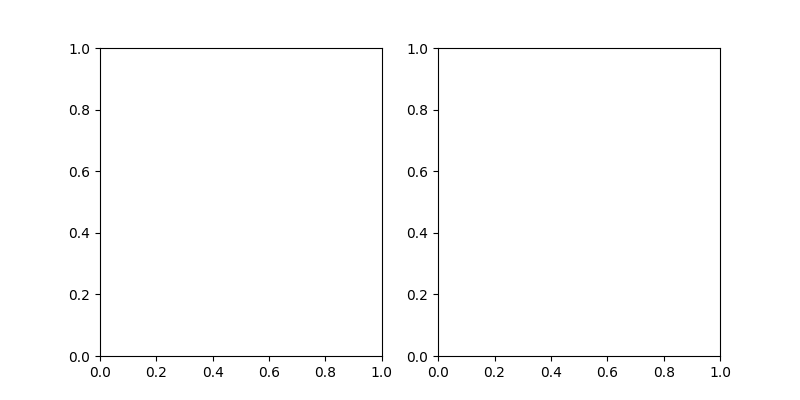

In [19]:
#DISPLAY CODE (separate, in case you just need the calculation).
%matplotlib ipympl
ani.pause() #In case another animation is running.

fig, axs = plt.subplots(1,2, figsize = (8,4)) #matplotlib's axis and figure notation is so annoying and obtuse...
xDim = len(finalMatrix)
yDim = len(finalMatrix[0])
zDim = len(finalMatrix[0][0])

xx = np.linspace(1, xDim, xDim)
yy = np.linspace(1, yDim, yDim)

def update(frame):
    axs[0].clear
    axs[1].clear
    zz = np.zeros((xDim, yDim))
    zz2 = np.zeros((xDim, yDim))
    for x in range(xDim):
        for y in range(yDim):
            zz[x][y] = finalMatrix[x][y][frame]
            zz2[x][y] = inputMatrix[x][y][frame]
    azimuth = axs[0].pcolor(zz2,vmin=-1,vmax=xDim)
    azimuth2 = axs[1].pcolor(zz,vmin=-1,vmax=xDim)
    axs[0].set(title=str(frame))
    axs[1].set(title=str(frame))
    #ax.set(xlim=[-0.5,5.5], ylim=[-0.5,5.5])

ani = animation.FuncAnimation(fig, update, frames=zDim, interval=100)

plt.show()